## **Prueba con modelo ARIMA para predicción de la energía solar** ##

In [160]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

In [161]:
data = pd.read_csv("capacidad_acumulada.csv", sep=';', encoding='utf-8')
df = pd.DataFrame(data)
df.head(10)

,Category,SOLAR,EOLICA,PCH
0,2019-01-06,"33,297270000000005",0,"0,7"
1,2019-01-10,"33,300670000000004",0,"0,7"
2,2019-01-16,"33,30263",0,"0,7"
3,2019-01-17,"33,305930000000004",0,"0,7"
4,2019-01-19,"33,34263000000001",0,"0,7"
5,2019-01-23,"33,34713000000001",0,"0,7"
6,2019-01-30,"33,395030000000006",0,"0,7"
7,2019-02-03,"41,45503000000001",0,"0,7"
8,2019-02-13,"41,46583000000001",0,"0,7"
9,2019-02-14,"41,48083000000001",0,"0,7"


In [162]:
print(df.shape)
df.describe()


(1731, 4)


,Category,SOLAR,EOLICA,PCH
count,1731,1731,1731,1731
unique,1731,1727,4,9
top,2019-01-06,"3089,2822170999975",0,"17,315945"
freq,1,4,827,672


In [163]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  1731 non-null   object
 1   SOLAR     1731 non-null   object
 2   EOLICA    1731 non-null   object
 3   PCH       1731 non-null   object
dtypes: object(4)
memory usage: 54.2+ KB
None


In [164]:
# Convertir las columnas numéricas (están con comas como separadores decimales)
df['SOLAR'] = df['SOLAR'].str.replace(',', '.').astype(float)
df['EOLICA'] = df['EOLICA'].str.replace(',', '.').astype(float)
df['PCH'] = df['PCH'].str.replace(',', '.').astype(float)

# Convertir Category a datetime si es necesario
df['Category'] = pd.to_datetime(df['Category'])

print("Datos convertidos correctamente")
print(df.dtypes)
print(df.head())

Datos convertidos correctamente
Category    datetime64[ns]
SOLAR              float64
EOLICA             float64
PCH                float64
dtype: object
    Category     SOLAR  EOLICA  PCH
0 2019-01-06  33.29727     0.0  0.7
1 2019-01-10  33.30067     0.0  0.7
2 2019-01-16  33.30263     0.0  0.7
3 2019-01-17  33.30593     0.0  0.7
4 2019-01-19  33.34263     0.0  0.7


In [165]:
# Renombramos la variable Category a Fecha
df = df.rename(columns={'Category': 'FECHA'})

# Convertimos la temporalidad diaria en temporalidad mensual
# Tomar la primera observación disponible de cada mes
df['year_month'] = df['FECHA'].dt.to_period('M')
df = df.loc[df.groupby('year_month')['FECHA'].idxmin()]
df = df.drop('year_month', axis=1)

# Ordenar por fecha y configurar índice temporal
df = df.sort_values('FECHA')
df = df.set_index('FECHA')


In [166]:
df

,SOLAR,EOLICA,PCH
FECHA,,,
2019-01-06,33.297270,0.0,0.700000
2019-02-03,41.455030,0.0,0.700000
2019-03-02,41.535115,0.0,0.700000
2019-04-04,42.192635,0.0,0.700000
2019-05-01,42.551345,0.0,0.700000
...,...,...,...
2025-04-05,2702.677217,41.0,20.615945
2025-07-31,2907.402217,41.0,20.615945
2025-08-31,2909.382217,41.0,20.615945


In [167]:
# Imputar valores faltantes (interpolación temporal)  
df['SOLAR'] = df['SOLAR'].interpolate(method='time')
df['EOLICA'] = df['EOLICA'].interpolate(method='time')  
df['PCH'] = df['PCH'].interpolate(method='time')

print(f"Dataset después de interpolación: {df.shape}")
df.tail()

Dataset después de interpolación: (80, 3)


,SOLAR,EOLICA,PCH
FECHA,,,
2025-04-05,2702.677217,41.0,20.615945
2025-07-31,2907.402217,41.0,20.615945
2025-08-31,2909.382217,41.0,20.615945
2025-10-23,3069.382217,41.0,20.615945
2025-11-01,3089.282217,41.0,20.615945


In [168]:
# Análisis de completitud temporal
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
observaciones_actuales = len(df)

# Calcular meses que deberían existir
inicio_mes = fecha_inicio.to_period('M')
fin_mes = fecha_fin.to_period('M')
meses_esperados = pd.period_range(inicio_mes, fin_mes, freq='M')
total_meses_esperados = len(meses_esperados)

# Identificar meses faltantes
meses_actuales = df.index.to_period('M')
meses_faltantes = meses_esperados.difference(meses_actuales)

print(f"Período: {fecha_inicio.strftime('%Y-%m')} a {fecha_fin.strftime('%Y-%m')}")
print(f"Observaciones: {observaciones_actuales}/{total_meses_esperados}")
print(f"Completitud: {(observaciones_actuales/total_meses_esperados*100):.1f}%")

if len(meses_faltantes) > 0:
    print(f"Meses faltantes: {len(meses_faltantes)}")
    for mes in meses_faltantes:
        print(f"  {mes}")
else:
    print("No hay meses faltantes")

Período: 2019-01 a 2025-11
Observaciones: 80/83
Completitud: 96.4%
Meses faltantes: 3
  2025-05
  2025-06
  2025-09


In [169]:
# Rellenar meses faltantes con valores NaN
if len(meses_faltantes) > 0:
    for mes_faltante in meses_faltantes:
        fecha_faltante = mes_faltante.to_timestamp()
        
        nueva_fila = pd.DataFrame({
            'SOLAR': [np.nan],
            'EOLICA': [np.nan],
            'PCH': [np.nan]
        }, index=[fecha_faltante])
        
        df = pd.concat([df, nueva_fila])
    
    df = df.sort_index()
    
    print(f"Serie completada: {len(df)} observaciones")
    print(f"Valores NaN añadidos: {df.isnull().sum().sum()}")
else:
    print("No se requiere completar la serie")

Serie completada: 83 observaciones
Valores NaN añadidos: 9


In [170]:
# Imputar valores faltantes usando interpolación temporal
df['SOLAR'] = df['SOLAR'].interpolate(method='time')
df['EOLICA'] = df['EOLICA'].interpolate(method='time')  
df['PCH'] = df['PCH'].interpolate(method='time')

print(f"Dataset final: {df.shape}")
print(f"Valores nulos restantes: {df.isnull().sum().sum()}")

Dataset final: (83, 3)
Valores nulos restantes: 0


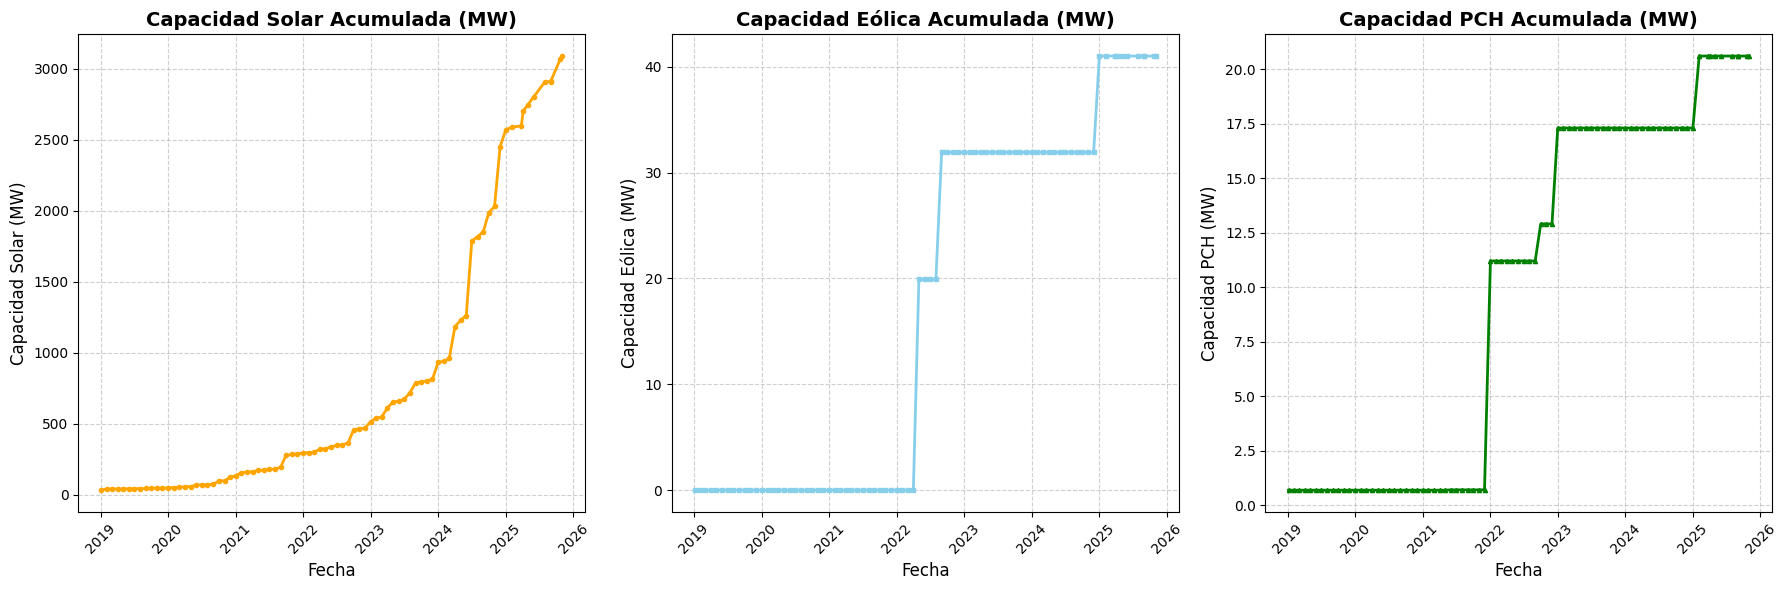

In [171]:
# Graficar las series de tiempo finales por tipo de energía
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Energía Solar
axes[0].plot(df.index, df['SOLAR'], color='orange', linewidth=2, marker='o', markersize=3)
axes[0].set_title('Capacidad Solar Acumulada (MW)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Capacidad Solar (MW)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45)

# Subplot 2: Energía Eólica
axes[1].plot(df.index, df['EOLICA'], color='skyblue', linewidth=2, marker='s', markersize=3)
axes[1].set_title('Capacidad Eólica Acumulada (MW)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Capacidad Eólica (MW)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)

# Subplot 3: PCH (Pequeñas Centrales Hidroeléctricas)
axes[2].plot(df.index, df['PCH'], color='green', linewidth=2, marker='^', markersize=3)
axes[2].set_title('Capacidad PCH Acumulada (MW)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Fecha', fontsize=12)
axes[2].set_ylabel('Capacidad PCH (MW)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Análisis ARIMA para Energía Solar**

## Selección automática del mejor modelo ARIMA usando auto_arima

Usaremos la librería `pmdarima` para encontrar automáticamente los mejores parámetros (p,d,q) para el modelo ARIMA de la serie de energía solar.

In [172]:
# Importar auto_arima para selección automática de parámetros
from pmdarima import auto_arima

In [173]:
# Extraer la serie temporal de energía solar
serie_solar = df['SOLAR']

print(f"Serie temporal: {len(serie_solar)} observaciones")
print(f"Período: {serie_solar.index.min().strftime('%Y-%m')} a {serie_solar.index.max().strftime('%Y-%m')}")
print(f"Media: {serie_solar.mean():.2f} MW, Desviación: {serie_solar.std():.2f} MW")

Serie temporal: 83 observaciones
Período: 2019-01 a 2025-11
Media: 790.00 MW, Desviación: 952.33 MW


In [174]:
# Configurar y ajustar modelo AutoARIMA
from pmdarima import auto_arima

modelo_auto = auto_arima(
    serie_solar,                    # Serie temporal
    start_p=0, start_q=0,           # Parámetros iniciales ARIMA
    max_p=3, max_q=3,               # Máximos parámetros p y q
    start_d=0, max_d=2,             # Diferenciación máxima
    seasonal=True,                  # Considerar estacionalidad
    m=12,                           # Período estacional (12 meses)
    start_P=0, start_Q=0,           # Parámetros estacionales iniciales
    max_P=2, max_Q=2, max_D=1,      # Máximos parámetros estacionales
    test='adf',                     # Test Augmented Dickey-Fuller
    stepwise=True,                  # Búsqueda stepwise (más rápida)
    suppress_warnings=True,         # Suprimir advertencias
    error_action='ignore',          # Ignorar errores durante la búsqueda
    random_state=42,                # Semilla para reproducibilidad
    n_fits=50                       # Número máximo de modelos a probar
)

print("Búsqueda AutoARIMA completada")

Búsqueda AutoARIMA completada


In [175]:
# Resultados del modelo
orden = modelo_auto.order
orden_estacional = modelo_auto.seasonal_order
aic = modelo_auto.aic()

print(f"Modelo: ARIMA{orden} x {orden_estacional}")
print(f"AIC: {aic:.2f}")
print(modelo_auto.summary())

Modelo: ARIMA(1, 2, 3) x (0, 0, 0, 12)
AIC: 927.95
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(1, 2, 3)   Log Likelihood                -458.973
Date:               sáb, 08 nov. 2025   AIC                            927.946
Time:                        19:05:32   BIC                            939.918
Sample:                             0   HQIC                           932.749
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4394      0.276     -1.593      0.111      -0.980       0.101
ma.L1         -0.5584      0.190     -2.942      0.003      -0.930      -0.186
m

In [176]:
# Extraer residuos del modelo
residuos = modelo_auto.resid()
print(f"Residuos: {len(residuos)} observaciones")
print(f"Media: {residuos.mean():.6f}, Desviación: {residuos.std():.4f}")

Residuos: 83 observaciones
Media: 2.171822, Desviación: 68.5104


In [181]:
# Estadísticas descriptivas de los residuos
print("📈 ESTADÍSTICAS DESCRIPTIVAS DE LOS RESIDUOS")
print("=" * 45)
print(f"Media: {residuos.mean():.6f}")
print(f"Mediana: {residuos.median():.6f}")
print(f"Desviación estándar: {residuos.std():.6f}")
print(f"Mínimo: {residuos.min():.6f}")
print(f"Máximo: {residuos.max():.6f}")
print(f"Asimetría (Skewness): {residuos.skew():.6f}")
print(f"Curtosis: {residuos.kurtosis():.6f}")

# Información sobre la distribución
print(f"\n INTERPRETACIÓN INICIAL:")
if abs(residuos.mean()) < 0.01:
    print("Media cercana a 0 - Buen signo")
else:
    print("Media no cercana a 0 - Posible sesgo")

if abs(residuos.skew()) < 0.5:
    print("Asimetría aceptable")
else:
    print("Asimetría alta - Distribución sesgada")

📈 ESTADÍSTICAS DESCRIPTIVAS DE LOS RESIDUOS
Media: 2.171822
Mediana: -0.814607
Desviación estándar: 68.510393
Mínimo: -198.312999
Máximo: 400.341714
Asimetría (Skewness): 2.159471
Curtosis: 14.785497

 INTERPRETACIÓN INICIAL:
Media no cercana a 0 - Posible sesgo
Asimetría alta - Distribución sesgada


In [182]:
# Pruebas de supuestos de los residuos
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats as scipy_stats
from statsmodels.stats.stattools import jarque_bera

# Prueba de normalidad - Jarque-Bera
jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(residuos.dropna())
print(f"Jarque-Bera - Estadístico: {jb_stat:.4f}, P-valor: {jb_pvalue:.6f}")

# Prueba de normalidad - Shapiro-Wilk
if len(residuos.dropna()) <= 5000:
    sw_stat, sw_pvalue = scipy_stats.shapiro(residuos.dropna())
    print(f"Shapiro-Wilk - Estadístico: {sw_stat:.4f}, P-valor: {sw_pvalue:.6f}")

# Prueba de autocorrelación - Ljung-Box
alpha = 0.05
max_lags = min(10, len(residuos.dropna()) // 4)
ljung_box = acorr_ljungbox(residuos.dropna(), lags=max_lags, return_df=True)

ultimo_lag = ljung_box.index[-1]
lb_pvalue_final = ljung_box.loc[ultimo_lag, 'lb_pvalue']
print(f"Ljung-Box (lag {ultimo_lag}) - P-valor: {lb_pvalue_final:.4f}")

# Prueba de homocedasticidad - Breusch-Pagan
valores_ajustados = modelo_auto.fittedvalues()
import statsmodels.api as sm_reg
X = sm_reg.add_constant(valores_ajustados)

try:
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuos.dropna(), X[:len(residuos.dropna())])
    print(f"Breusch-Pagan - Estadístico: {bp_stat:.4f}, P-valor: {bp_pvalue:.6f}")
except Exception as e:
    residuos_cuadrados = residuos.dropna() ** 2
    valores_ajustados_clean = valores_ajustados[:len(residuos_cuadrados)]
    correlacion = scipy_stats.pearsonr(valores_ajustados_clean, residuos_cuadrados)
    print(f"Correlación residuos² vs valores ajustados: {correlacion[0]:.4f}, P-valor: {correlacion[1]:.4f}")

Jarque-Bera - Estadístico: 724.4502, P-valor: 0.000000
Shapiro-Wilk - Estadístico: 0.7103, P-valor: 0.000000
Ljung-Box (lag 10) - P-valor: 0.6747
Breusch-Pagan - Estadístico: 4.7312, P-valor: 0.029620



 GENERANDO GRÁFICOS DE DIAGNÓSTICO...


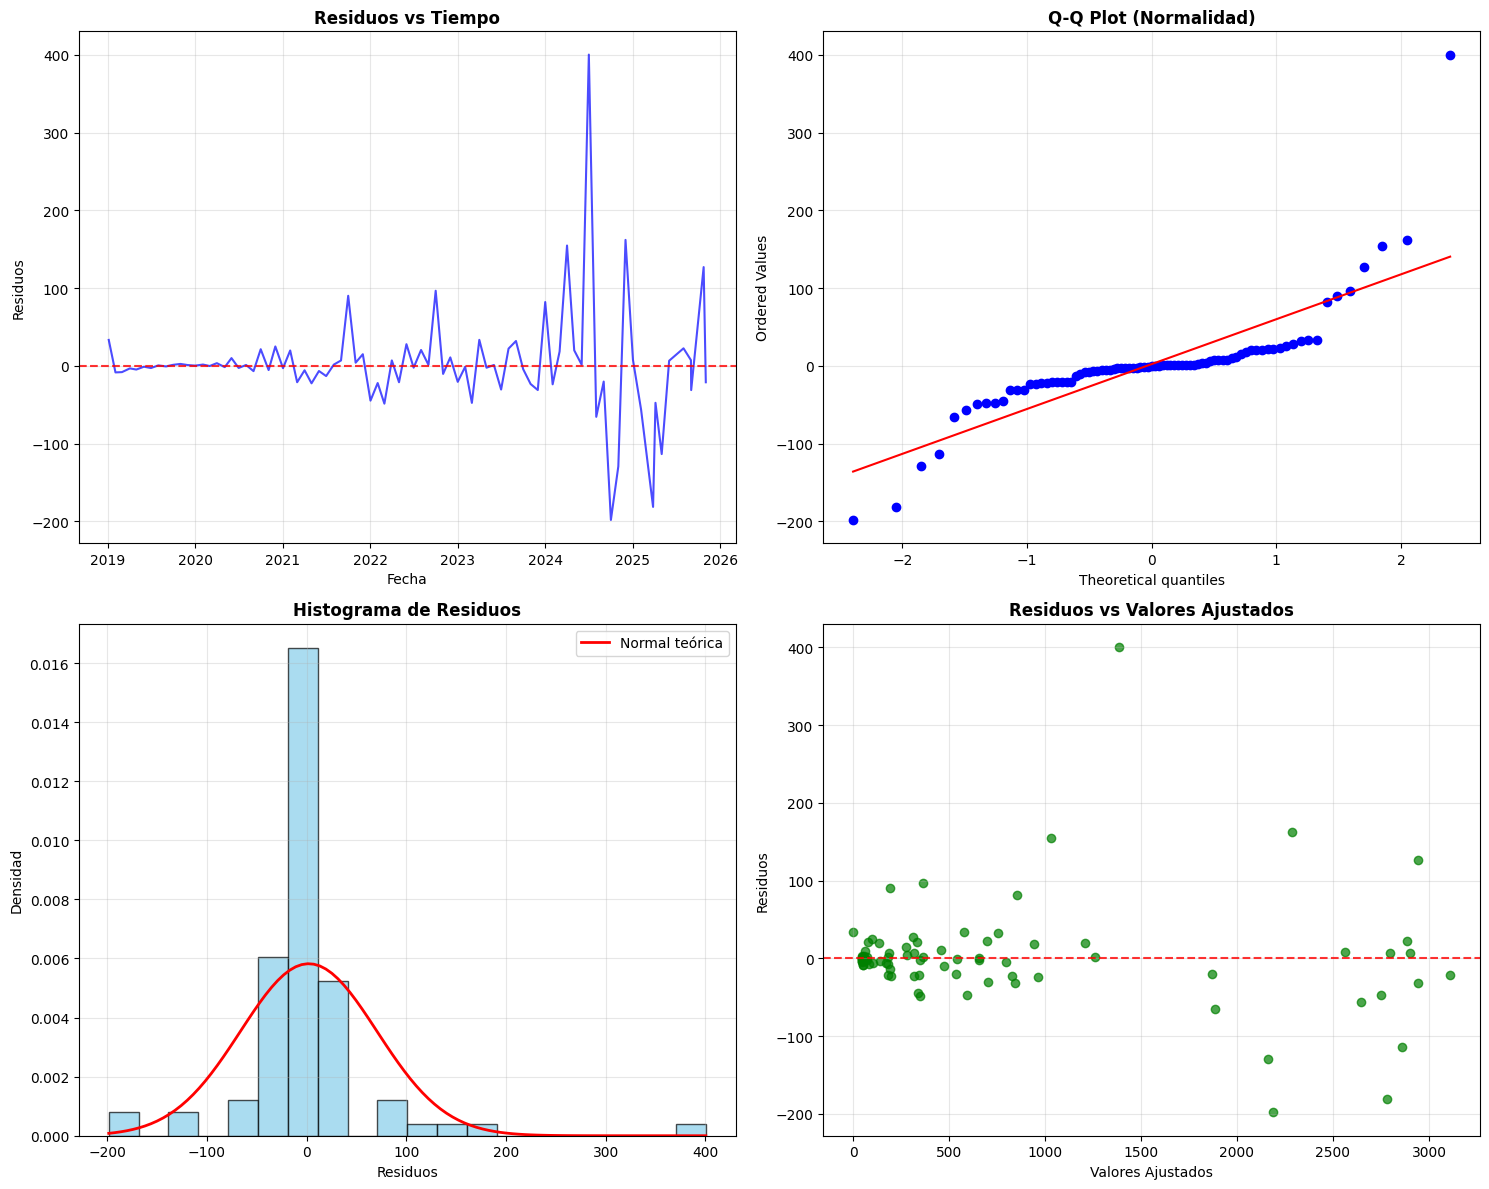

In [184]:
# VISUALIZACIÓN DE LOS RESIDUOS
print("\n GENERANDO GRÁFICOS DE DIAGNÓSTICO...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Serie temporal de residuos
axes[0,0].plot(residuos.index, residuos, color='blue', alpha=0.7)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0,0].set_title('Residuos vs Tiempo', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Residuos')
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q Plot para normalidad
scipy_stats.probplot(residuos.dropna(), dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Histograma con curva normal
axes[1,0].hist(residuos.dropna(), bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Agregar curva normal teórica
x = np.linspace(residuos.min(), residuos.max(), 100)
axes[1,0].plot(x, scipy_stats.norm.pdf(x, residuos.mean(), residuos.std()), 
               'r-', lw=2, label='Normal teórica')
axes[1,0].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Densidad')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Residuos vs Valores Ajustados (heterocedasticidad)
valores_ajustados_plot = modelo_auto.fittedvalues()
axes[1,1].scatter(valores_ajustados_plot, residuos, alpha=0.7, color='green')
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1,1].set_title('Residuos vs Valores Ajustados', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Valores Ajustados')
axes[1,1].set_ylabel('Residuos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [185]:
# Resumen de validación de supuestos
normalidad_ok = jb_pvalue > alpha
autocorr_ok = lb_pvalue_final > alpha

try:
    homoced_ok = bp_pvalue > alpha
except:
    homoced_ok = abs(correlacion[0]) < 0.3 or correlacion[1] > alpha

supuestos_cumplidos = sum([normalidad_ok, autocorr_ok, homoced_ok])

print(f"Normalidad: {'Cumplido' if normalidad_ok else 'No cumplido'}")
print(f"No autocorrelación: {'Cumplido' if autocorr_ok else 'No cumplido'}")
print(f"Homocedasticidad: {'Cumplido' if homoced_ok else 'No cumplido'}")
print(f"\nSupuestos cumplidos: {supuestos_cumplidos}/3")
print(f"Modelo ARIMA{orden} x {orden_estacional}[12]")
print(f"AIC: {aic:.2f}")

Normalidad: No cumplido
No autocorrelación: Cumplido
Homocedasticidad: No cumplido

Supuestos cumplidos: 1/3
Modelo ARIMA(1, 2, 3) x (0, 0, 0, 12)[12]
AIC: 927.95


Por lo anterior no sería factible aplicar un modelo ARIMA a esta serie de tiempo